In [1]:
#import all Qiskit libraries
from qiskit import *
import numpy as np
from qiskit.visualization import plot_histogram

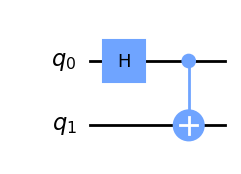

In [2]:
# Number of qubits needed to model real distribution
REAL_DIST_NQUBITS = 2
real_circuit = QuantumCircuit(REAL_DIST_NQUBITS)
real_circuit.h(0)
real_circuit.cx(0, 1);
real_circuit.draw()

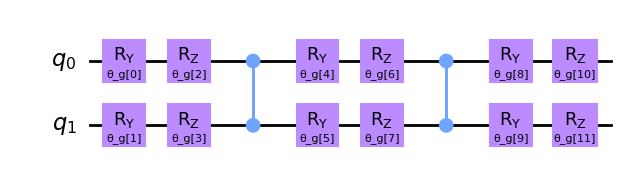

In [3]:
from qiskit.circuit.library import TwoLocal
generator = TwoLocal(REAL_DIST_NQUBITS,
                     # Parameterized single qubit rotations
                     ['ry', 'rz'],
                     'cz',  # Entangling gate
                     'full', # Entanglement structure - all to all
                     reps=2, # Number of layers
                     parameter_prefix='θ_g',
                     name='Generator')
generator = generator.decompose()
generator.draw()

In [4]:
#Create the Variation quantum discriminator
#We now define the ansatz for the QGAN discriminator. In this case, instead of using TwoLocal, we create a custom ansatz with a ParameterVector

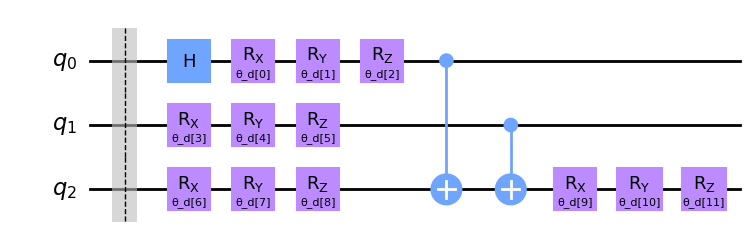

In [5]:
from qiskit.circuit import ParameterVector

disc_weights = ParameterVector('θ_d', 12)
discriminator = QuantumCircuit(3, name="Discriminator")
discriminator.barrier()
discriminator.h(0)
discriminator.rx(disc_weights[0], 0)
discriminator.ry(disc_weights[1], 0)
discriminator.rz(disc_weights[2], 0)
discriminator.rx(disc_weights[3], 1)
discriminator.ry(disc_weights[4], 1)
discriminator.rz(disc_weights[5], 1)
discriminator.rx(disc_weights[6], 2)
discriminator.ry(disc_weights[7], 2)
discriminator.rz(disc_weights[8], 2)
discriminator.cx(0, 2)
discriminator.cx(1, 2)
discriminator.rx(disc_weights[9], 2)
discriminator.ry(disc_weights[10], 2)
discriminator.rz(disc_weights[11], 2)
discriminator.draw()

In [6]:
#Compile the GAN
#construct the two circuits forming the QGAN. 
#the first circuit feeds generated quantum state into the discriminator
#the second circuit is comprised of the discriminator applied on the real state

In [7]:
N_GPARAMS = generator.num_parameters
N_DPARAMS = discriminator.num_parameters

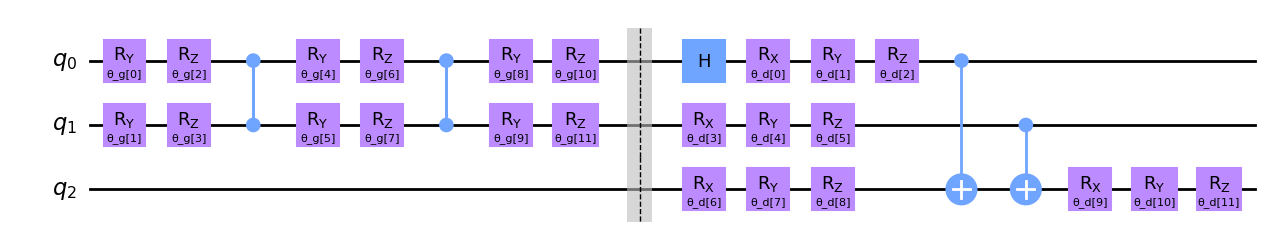

In [8]:
# Need an extra qubit for the discriminator
gen_disc_circuit = QuantumCircuit(REAL_DIST_NQUBITS+1)
gen_disc_circuit.compose(generator, inplace=True)
gen_disc_circuit.compose(discriminator, inplace=True)
gen_disc_circuit.draw()  

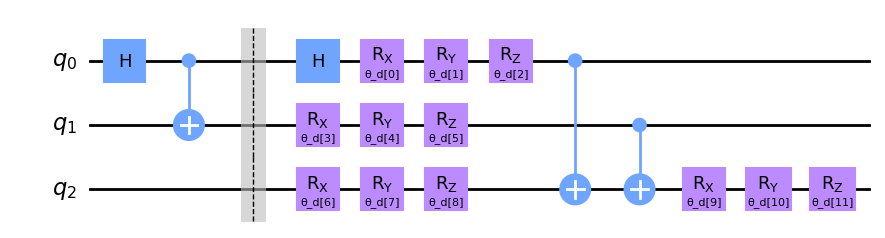

In [9]:
#define the parameterized circuit linking the target distribution with the variational discriminator.
real_disc_circuit = QuantumCircuit(REAL_DIST_NQUBITS+1)
real_disc_circuit.compose(real_circuit, inplace=True)
real_disc_circuit.compose(discriminator, inplace=True)
real_disc_circuit.draw()

In [10]:
pip install tensorflow==2.12


[notice] A new release of pip available: 23.1.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [11]:
import tensorflow as tf

2023-07-30 23:57:40.665518: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-30 23:57:40.729317: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-30 23:57:40.730761: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-30 23:57:41.758249: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [12]:
#Using Statevector to retrieve statevector of a given circuit
from qiskit.quantum_info import Statevector

#Construct the cost function

def generator_cost(gen_params):
    """Generator cost function for the optimizer to minimize."""
    # .numpy() method extracts numpy array from TF tensor
    curr_params = np.append(disc_params.numpy(),
                            gen_params.numpy())
    state_probs = Statevector(gen_disc_circuit
                              .bind_parameters(curr_params)
                             ).probabilities()
    # Get total prob of measuring |1> on q2
    prob_fake_true = np.sum(state_probs[0b100:])
    cost = -prob_fake_true
    return cost

def discriminator_cost(disc_params):
    """Discriminator cost function for the optimizer to minimize."""
    # .numpy() method extracts numpy array from TF tensor
    curr_params = np.append(disc_params.numpy(),
                            gen_params.numpy())
    gendisc_probs = Statevector(gen_disc_circuit
                                .bind_parameters(curr_params)
                               ).probabilities()
    realdisc_probs = Statevector(real_disc_circuit.
                                 bind_parameters(disc_params.numpy())
                                ).probabilities()
    # Get total prob of measuring |1> on q2
    prob_fake_true = np.sum(gendisc_probs[0b100:])
    # Get total prob of measuring |1> on q2
    prob_real_true = np.sum(realdisc_probs[0b100:])
    cost = prob_fake_true - prob_real_true
    return cost

In [13]:
#define a helper function to calculate the Kullback-Leibler divergence between the model and target distribution. This is a common metric used to track the generator's progress while training since it effectively measures the distance between two distributions. 
#A lower KL divergence indicates that the two distributions are similar
#0 value implies equivalence.

In [14]:
def calculate_kl_div(model_distribution: dict, target_distribution: dict):
    """Gauge model performance using Kullback Leibler Divergence"""
    kl_div = 0
    for bitstring, p_data in target_distribution.items():
        if np.isclose(p_data, 0, atol=1e-8):
            continue
        if bitstring in model_distribution.keys():
            kl_div += (p_data * np.log(p_data)
                 - p_data * np.log(model_distribution[bitstring]))
        else:
            kl_div += p_data * np.log(p_data) - p_data * np.log(1e-6)
    return kl_div

In [15]:
pip install 'qiskit-machine-learning[sparse]'


[notice] A new release of pip available: 23.1.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [16]:
import sparse

In [17]:
from qiskit.primitives import Sampler
from qiskit_machine_learning.neural_networks import SamplerQNN
#from qiskit.algorithms.gradients import ParamShiftSamplerGradient #BaseSamplerGradient  #LinCombSamplerGradient 
sampler = Sampler()


from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeVigo
from qiskit_aer.primitives import Sampler as AerSampler

# fake providers contain data from real IBM Quantum devices stored in Qiskit Terra,
# and are useful for extracting realistic noise models.
device = FakeVigo()

coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)

print(noise_model)

seed = 200
noisy_sampler = AerSampler(
    backend_options={
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    },
    run_options={"seed": seed, "shots": 1000},
    transpile_options={"seed_transpiler": seed},
)


# specify SamplerQNN to update QGEN weights
gen_qnn = SamplerQNN(
    circuit=gen_disc_circuit,  
    input_params=gen_disc_circuit.parameters[:N_DPARAMS],
    weight_params=gen_disc_circuit.parameters[N_DPARAMS:],
    sparse=True,
    sampler=noisy_sampler
)

# specify QNNs to update QDIS weights
disc_fake_qnn = SamplerQNN(
    circuit=gen_disc_circuit, 
    input_params=gen_disc_circuit.parameters[N_DPARAMS:],
    weight_params=gen_disc_circuit.parameters[:N_DPARAMS],
    sparse=True,
    sampler=noisy_sampler
)

disc_real_qnn = SamplerQNN(
    circuit=real_disc_circuit,
    input_params=[],
    weight_params=gen_disc_circuit.parameters[:N_DPARAMS],
    sparse=True,
    sampler=noisy_sampler
)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['id', 'cx', 'x', 'sx', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (3, 4)), ('cx', (4, 3)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 1)), ('cx', (1, 0)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]


In [18]:
import pickle # to serialize and deserialize variables

In [19]:
# Initialize parameters
init_gen_params = np.random.uniform(low=-np.pi,
                                    high=np.pi,
                                    size=(N_GPARAMS,))
init_disc_params = np.random.uniform(low=-np.pi,
                                     high=np.pi,
                                     size=(N_DPARAMS,))
gen_params = tf.Variable(init_gen_params)
disc_params = tf.Variable(init_disc_params)

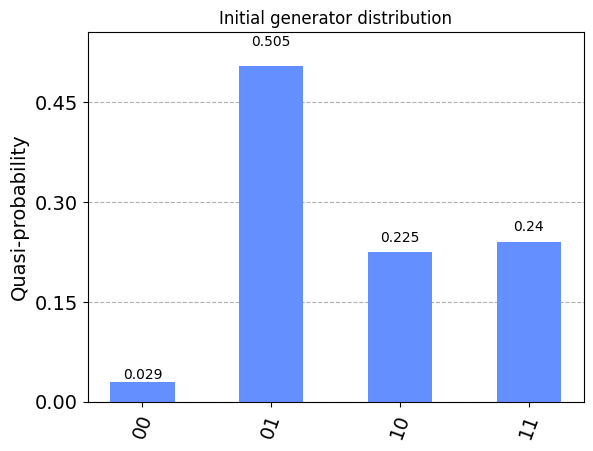

In [20]:
#Starting point for the generator created from random weights
init_gen_circuit = generator.bind_parameters(init_gen_params)
init_prob_dict = Statevector(init_gen_circuit).probabilities_dict()

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(1, 1, sharey=True)
ax1.set_title("Initial generator distribution")
plot_histogram(init_prob_dict, ax=ax1)

In [21]:
# Initialize Adam optimizer from Keras
generator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.02) #, weight_decay=0.001, use_ema=True)
discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.02) #, weight_decay=0.001, use_ema=True)

In [22]:
# Initialize variables to track metrics while training
best_gen_params = tf.Variable(init_gen_params)
gloss = []
dloss = []
kl_div = []

In [23]:
TABLE_HEADERS = "Epoch | Generator cost | Discriminator cost | KL Div. |"
print(TABLE_HEADERS)
for epoch in range(100):
    #--- Quantum discriminator parameter updates ---#
    D_STEPS = 5 # N discriminator updates per generator update
    for disc_train_step in range(D_STEPS):
        # Partial derivatives wrt θ_D
        d_fake = disc_fake_qnn.backward(gen_params, disc_params
                                       )[1].todense()[0, 0b100:]
        d_fake = np.sum(d_fake, axis=0)
        d_real = disc_real_qnn.backward([], disc_params
                                       )[1].todense()[0, 0b100:]
        d_real = np.sum(d_real, axis=0)
        # Recall Cost_D structure
        grad_dcost = [d_fake[i] - d_real[i] for i in range(N_DPARAMS)]
        grad_dcost = tf.convert_to_tensor(grad_dcost)
        # Update disc params with gradient
        discriminator_optimizer.apply_gradients(zip([grad_dcost],
                                                    [disc_params]))
        # Track discriminator loss
        if disc_train_step % D_STEPS == 0:
            dloss.append(discriminator_cost(disc_params))

    #--- Quantum generator parameter updates ---#
    for gen_train_step in range(1):
        # Compute partial derivatives of prob(fake|true) wrt each
        # generator weight
        grads = gen_qnn.backward(disc_params, gen_params)
        grads = grads[1].todense()[0][0b100:]
        # Recall Cost_G structure and the linearity of
        # the derivative operation
        grads = -np.sum(grads, axis=0)
        grads = tf.convert_to_tensor(grads)
        # Update gen params with gradient
        generator_optimizer.apply_gradients(zip([grads], [gen_params]))
        gloss.append(generator_cost(gen_params))

    #--- Track KL and save best performing generator weights ---#
    # Create test circuit with updated gen parameters
    gen_checkpoint_circuit = generator.bind_parameters(gen_params.numpy())
    # Retrieve probability distribution of current generator
    gen_prob_dict = Statevector(gen_checkpoint_circuit
                               ).probabilities_dict()
    # Constant real probability distribution
    real_prob_dict = Statevector(real_circuit).probabilities_dict()
    current_kl = calculate_kl_div(gen_prob_dict, real_prob_dict)
    kl_div.append(current_kl)
    if np.min(kl_div) == current_kl:
        # New best
        # serialize & deserialize to simply ensure zero links
        best_gen_params = pickle.loads(pickle.dumps(gen_params))
    if epoch % 10 == 0:
        # print table every 10 epochs
        for header, val in zip(TABLE_HEADERS.split('|'),
                              (epoch, gloss[-1], dloss[-1], kl_div[-1])):
            print(f"{val:.3g} ".rjust(len(header)), end="|")
        print()

Epoch | Generator cost | Discriminator cost | KL Div. |
    0 |         -0.233 |              -0.29 |    1.78 |
   10 |           -0.4 |             -0.453 |     1.7 |
   20 |         -0.476 |             -0.482 |    1.63 |
   30 |          -0.51 |             -0.479 |    1.55 |
   40 |         -0.539 |             -0.461 |    1.48 |
   50 |          -0.57 |             -0.432 |    1.42 |
   60 |         -0.602 |               -0.4 |    1.36 |
   70 |         -0.637 |             -0.366 |    1.31 |
   80 |          -0.67 |             -0.332 |    1.27 |
   90 |         -0.701 |             -0.301 |    1.23 |


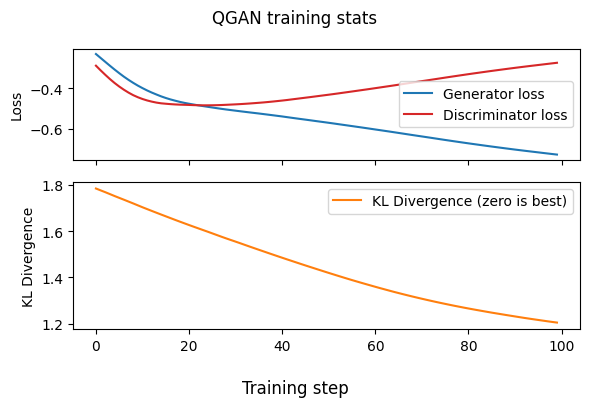

In [24]:
fig, (loss, kl) = plt.subplots(2, sharex=True,
                               gridspec_kw={'height_ratios': [0.75, 1]},
                               figsize=(6,4))
fig.suptitle('QGAN training stats')
fig.supxlabel('Training step')
loss.plot(range(len(gloss)), gloss, label="Generator loss")
loss.plot(range(len(dloss)), dloss, label="Discriminator loss",
          color="C3")
loss.legend()
loss.set(ylabel='Loss')
kl.plot(range(len(kl_div)), kl_div, label="KL Divergence (zero is best)",
        color="C1")
kl.set(ylabel='KL Divergence')
kl.legend()
fig.tight_layout();

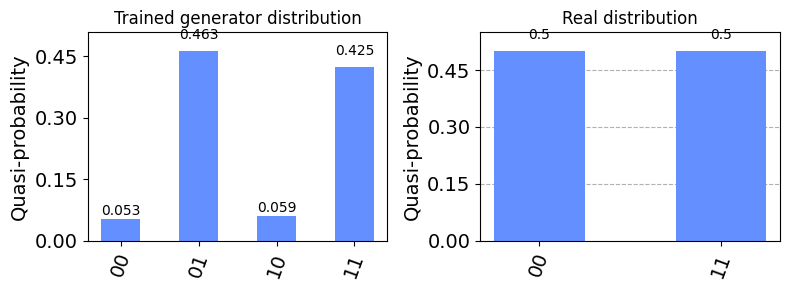

In [25]:
# Create test circuit with new parameters
gen_checkpoint_circuit = generator.bind_parameters(
    best_gen_params.numpy())
gen_prob_dict = Statevector(gen_checkpoint_circuit).probabilities_dict()
real_prob_dict = Statevector(real_circuit).probabilities_dict() # constant
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
plot_histogram(gen_prob_dict, ax=ax1)
ax1.set_title("Trained generator distribution")
plot_histogram(real_prob_dict, ax=ax2)
ax2.set_title("Real distribution")
fig.tight_layout()

In [26]:
#from qiskit_ibm_runtime import QiskitRuntimeService

#service = QiskitRuntimeService(channel="ibm_cloud", \
#                               token="Zzne8G5TAZLOjWe0HpsDKSzcrt0iKdw2ldEO91qC7L1B", \
#                               instance="crn:v1:bluemix:public:quantum-computing:us-east:a/0e8a378ecdfa41538ab40d3fbb042607:2edd4104-6cf2-406e-a3b7-39f83f82da00::")